In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder

# default module
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns

from sklearn.model_selection import KFold

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)

## utils

In [30]:
def select_important_feautre(columns, feature_importance, num):
    
    #딕셔너리
    dic = {}
    for value in [list(v) for v in zip(columns, feature_importance)]:
        dic[str(value[1])] = value[0] 
    
    #피처 중요도
    f_i = list(feature_importance)
    f_i.sort(reverse=True)
    
    
    #n개 뽑기
    result = []
    for i in range(0, num):
        result.append(dic[str(f_i[i])])
    
    return result

In [31]:
def cross_val_score_custom(model, x, y, cv, dev = 0):
    
    print('\n\n')
    
    result = []
    
    for train_idx, test_idx in cv.split(x):
        
        new_x_train = x.iloc[train_idx, :]
        new_y_train = y.iloc[train_idx]
        
        new_x_test = x.iloc[test_idx, :]
        new_y_test = y.iloc[test_idx]
        
        model.fit(new_x_train, new_y_train)
        
        temp = np.mean(f1_score(new_y_test, model.predict(new_x_test), average=None))
        
        if dev:
            print('dev Mode # : {}'.format(temp))
        
        result.append(temp)
    
    print('\n\n')
    
    return np.mean(result)

In [32]:
def get_oof(model, x_train, y_train, x_test, k):
    
    le = LabelEncoder()
    le.fit(y_train)
    y_train = pd.Series(le.transform(y_train))
    
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.empty((k, x_test.shape[0]))
    
    for i, (train_idx, test_idx) in enumerate(KFold(n_splits=k).split(x_train)):
        
        print(i, sep=' ')
        
        x_tr = x_train.iloc[train_idx, :]
        y_tr = y_train.iloc[train_idx]
        x_te = x_train.iloc[test_idx, :]
        
        model.fit(x_tr, y_tr)

        oof_train[test_idx] = model.predict(x_te)
        oof_test_skf[i, :] = model.predict(x_test)
    
    # version 1
    # oof_test[:] = np.round(oof_test_skf.mean(axis=0))
    
    # version 2
    oof_test[:] = pd.DataFrame(oof_test_skf).apply(lambda v: v.value_counts().idxmax(), axis=0)
    
    oof_train = [int(v) for v in oof_train]
    oof_train = le.inverse_transform(oof_train)
    
    oof_test = [int(v) for v in oof_test]
    oof_test = le.inverse_transform(oof_test)
    
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [33]:
def temp(v):
    if v <= 4:
        return 0
    elif v <=7:
        return 1
    elif v <= 10:
        return 2
    else:
        return 3

In [34]:
def remove_outlier(data, percent):
    data = data.copy()
    thres = data.quantile([percent])
    
    for col in data:
        if data[col].dtype == float or data[col].dtype == int:
            data.loc[data[col] > thres[col].values[0], col] = thres[col].values[0]
    
    return data

## data load

In [10]:
x_data_train = pd.read_csv('./data_train.csv').drop(['hash'], axis=1)#.iloc[:,:-100]#.astype(int)
x_data_yesun = pd.read_csv('./data_yesun.csv').drop(['hash'], axis=1)#.iloc[:,:-100]#.astype(int)

In [11]:
y_data_train = pd.read_excel('./result_train/label.xlsx').sort_values(by='hash')
label_train = y_data_train['hash'].to_frame()
is_mal_train = y_data_train['is_mal'].to_frame()

y_data_yesun = pd.read_excel('./result_yesun/label.xlsx').sort_values(by='hash')
label_yesun = y_data_yesun['hash'].to_frame()
is_mal_yesun = y_data_yesun['is_mal'].to_frame()

# y_data_pre1 = pd.read_excel('./result_pre1/label.xlsx').sort_values(by='hash')
# label_pre1 = y_data_pre1['hash'].to_frame()
# is_mal_pre1 = y_data_pre1['is_mal'].to_frame()

# y_data_pre2 = pd.read_excel('./result_pre2/label.xlsx').sort_values(by='hash')
# label_pre2 = y_data_pre2['hash'].to_frame()
# is_mal_pre2 = y_data_pre2['is_mal'].to_frame()

In [12]:
# x_data_pre1 = pd.read_csv('./data_pre1.csv').drop(['hash'], axis=1).astype(int)
# x_data_pre2 = pd.read_csv('./data_pre2.csv').drop(['hash'], axis=1).astype(int)

In [22]:
x_data_train = remove_outlier(x_data_train, 0.9)
x_data_yesun = remove_outlier(x_data_yesun, 0.9)

# 개별 피처 엔지니어링

In [20]:
x_data = pd.concat([x_data_train, is_mal_train], axis = 1)

In [21]:
def show_feature_plot(data, col_name, log = False):

    if log:
        sns.distplot(np.log(data[col_name][data.is_mal == 0] + 1), color='blue')
        sns.distplot(np.log(data[col_name][data.is_mal == 1] + 1), color='red')
    
    else:
        sns.distplot(data[col_name][data.is_mal == 0], color='blue')
        sns.distplot(data[col_name][data.is_mal == 1], color='red')

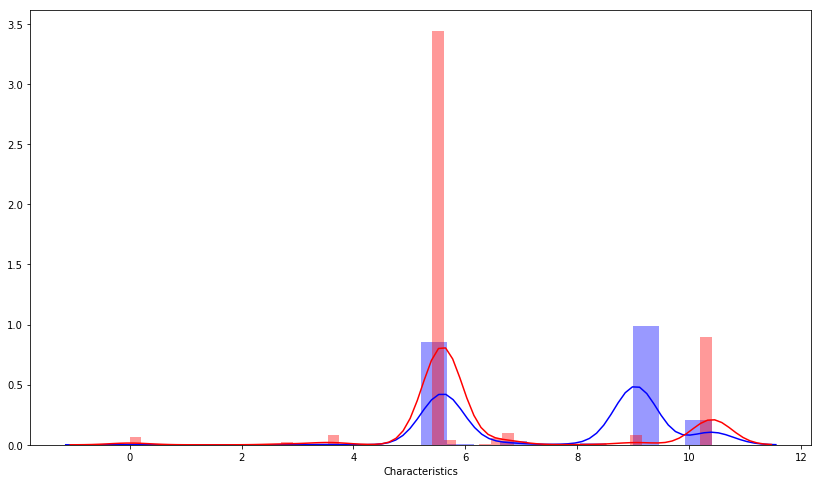

In [172]:
show_feature_plot(x_data, 'Characteristics', log = True)

In [174]:
x_data['Characteristics'] = np.log(x_data.Characteristics + 1)
x_data['Characteristics'] = x_data.Characteristics.map(temp)

In [175]:
x_data_yesun['Characteristics'] = np.log(x_data_yesun.Characteristics + 1)
x_data_yesun['Characteristics'] = x_data_yesun.Characteristics.map(temp)

In [24]:
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=28, bootstrap=True)
rf.fit(x_data_train, is_mal_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
print(rf.score(x_data_train, is_mal_train))
print(rf.score(x_data_yesun, is_mal_yesun))

1.0
0.9529


In [24]:
values = np.array([list(v) for v in sorted(zip(x_data_train.columns, rf.feature_importances_), key=lambda x: x[1] * -1)])
imp = pd.DataFrame(values[:,1], index = values[:,0], columns=["feature_importance"])
imp.feature_importance = imp.feature_importance.astype(float)

In [35]:
imp.head(20)

,feature_importance
PeDll,0.046839
PeExe,0.041470
ImageBase,0.040826
ExportSize,0.031440
EntropyMax,0.023816
Characteristics,0.023321
CheckSum,0.019649
TotalSizePE,0.015155
GeneratedCheckSum,0.014823
EntropyStd,0.013728


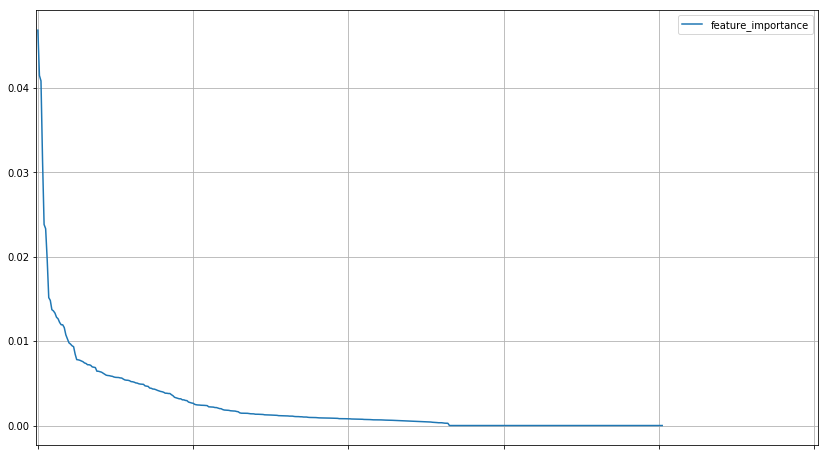

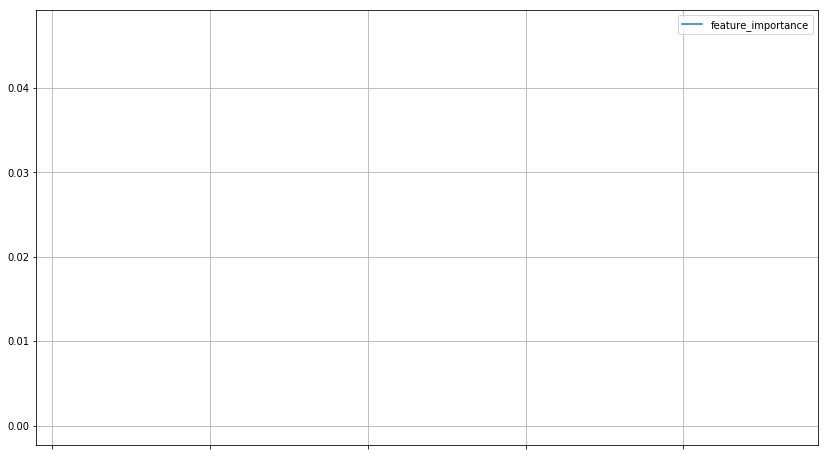

In [25]:
num = 502
imp.plot(figsize=(14,8), grid=True, xlim=(-1,num))
imp.plot(figsize=(14,8), grid=True, xlim=(num,len(x_data_train.columns)))

In [23]:
x_data_t = x_data_train[imp.index[:num]]
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=28)
rf.fit(x_data_t, is_mal_train)

NameError: name 'imp' is not defined

In [170]:
print(rf.score(x_data_yesun[imp.index[:num]], is_mal_yesun))

0.9538


In [70]:
x_data_train['AddressOfEntryPoint'] = x_data_train['AddressOfEntryPoint'].map(temp)
x_data_yesun['AddressOfEntryPoint'] = x_data_yesun['AddressOfEntryPoint'].map(temp)

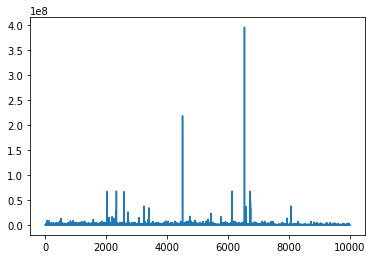

In [24]:
a.AddressOfEntryPoint.plot()

In [728]:
x_data_train_yesun = pd.concat([x_data_train, x_data_yesun])

In [22]:
x_data_train

,AddressOfEntryPoint,Characteristics,CheckSum,DebugSize,ExportSize,FileAlignment,GeneratedCheckSum,IatRva,ImageBase,Machine,...,asm_img_91,asm_img_92,asm_img_93,asm_img_94,asm_img_95,asm_img_96,asm_img_97,asm_img_98,asm_img_99,asm_img_100
0,30542.0,8450.0,6.088100e+04,0.0,0.0,4096.0,96371.0,30464.0,4194304.0,332.0,...,124.0,32.0,32.0,32.0,84.0,104.0,105.0,115.0,32.0,102.0
1,13118.0,271.0,5.289660e+05,0.0,0.0,512.0,564456.0,34208.0,4194304.0,332.0,...,32.0,84.0,104.0,105.0,115.0,32.0,102.0,105.0,108.0,101.0
2,11540.0,271.0,3.233720e+05,0.0,0.0,4096.0,293327.0,232692.0,4194304.0,332.0,...,32.0,84.0,104.0,105.0,115.0,32.0,102.0,105.0,108.0,101.0
3,203504.0,271.0,0.000000e+00,0.0,0.0,512.0,46406.0,207308.0,4194304.0,332.0,...,32.0,84.0,104.0,105.0,115.0,32.0,102.0,105.0,108.0,101.0
4,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5222.0,258.0,1.029980e+05,84.0,0.0,512.0,138488.0,69972.0,4194304.0,332.0,...,32.0,84.0,104.0,105.0,115.0,32.0,102.0,105.0,108.0,101.0
7,7894.0,271.0,0.000000e+00,28.0,0.0,4096.0,103643.0,8556.0,16777216.0,332.0,...,32.0,84.0,104.0,105.0,115.0,32.0,102.0,105.0,108.0,101.0
8,5383.0,258.0,5.617500e+04,28.0,0.0,512.0,50286.0,8836.0,4194304.0,332.0,...,32.0,84.0,104.0,105.0,115.0,32.0,102.0,105.0,108.0,101.0
9,841246.0,258.0,0.000000e+00,0.0,0.0,512.0,1087505.0,841168.0,4194304.0,332.0,...,124.0,32.0,32.0,32.0,84.0,104.0,105.0,115.0,32.0,102.0


In [729]:
is_mal_train_yesun = pd.concat([is_mal_train, is_mal_yesun])

## model

###### model 1

In [673]:
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, max_depth=28, bootstrap=True)

In [674]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, colsample_bytreeb=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=900, n_jobs = -1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [675]:
extree =  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=40, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [676]:
lightgb = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.65, learning_rate=0.005,
                        n_estimators=1400, num_leaves=90, objective='binary',
                        rnadom_state=501, reg_alpha=1, reg_lambda=1, subsample=0.7)

In [677]:
catboost = cb.CatBoostClassifier(depth=7, iterations=600, learning_rate=0.15, l2_leaf_reg=1)

In [678]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=28, random_state=0)

In [679]:
oof_train_rf, oof_test_rf = get_oof(rf, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

0
1
2
3
4


In [680]:
oof_train_tree, oof_test_tree = get_oof(tree, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

0
1
2
3
4


In [681]:
oof_train_extree, oof_test_extree = get_oof(extree, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

0
1
2
3
4


In [568]:
oof_train_lgb, oof_test_lgb = get_oof(lightgb, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

0
1
2
3
4


In [569]:
oof_train_cb, oof_test_cb = get_oof(catboost, x_data_train_yesun, is_mal_train_yesun, x_data_bonsun, 5)

0
0:	learn: 0.5542807	total: 575ms	remaining: 5m 44s
1:	learn: 0.4745735	total: 1.17s	remaining: 5m 50s
2:	learn: 0.4221712	total: 1.77s	remaining: 5m 51s
3:	learn: 0.3760486	total: 2.35s	remaining: 5m 50s
4:	learn: 0.3437321	total: 2.94s	remaining: 5m 49s
5:	learn: 0.3232187	total: 3.51s	remaining: 5m 47s
6:	learn: 0.3040999	total: 4.07s	remaining: 5m 44s
7:	learn: 0.2871840	total: 4.64s	remaining: 5m 43s
8:	learn: 0.2763260	total: 5.2s	remaining: 5m 41s
9:	learn: 0.2622363	total: 5.77s	remaining: 5m 40s
10:	learn: 0.2534726	total: 6.33s	remaining: 5m 39s
11:	learn: 0.2463724	total: 6.9s	remaining: 5m 38s
12:	learn: 0.2384865	total: 7.46s	remaining: 5m 36s
13:	learn: 0.2309095	total: 8.03s	remaining: 5m 35s
14:	learn: 0.2233022	total: 8.59s	remaining: 5m 34s
15:	learn: 0.2191744	total: 9.13s	remaining: 5m 33s
16:	learn: 0.2139029	total: 9.68s	remaining: 5m 31s
17:	learn: 0.2105589	total: 10.2s	remaining: 5m 30s
18:	learn: 0.2081790	total: 10.8s	remaining: 5m 28s
19:	learn: 0.2046427	t

158:	learn: 0.0978642	total: 1m 27s	remaining: 4m 1s
159:	learn: 0.0975497	total: 1m 27s	remaining: 4m 1s
160:	learn: 0.0975387	total: 1m 28s	remaining: 4m 1s
161:	learn: 0.0970862	total: 1m 28s	remaining: 4m
162:	learn: 0.0970036	total: 1m 29s	remaining: 3m 59s
163:	learn: 0.0964678	total: 1m 30s	remaining: 3m 59s
164:	learn: 0.0961515	total: 1m 30s	remaining: 3m 58s
165:	learn: 0.0959752	total: 1m 31s	remaining: 3m 58s
166:	learn: 0.0955498	total: 1m 31s	remaining: 3m 58s
167:	learn: 0.0955361	total: 1m 32s	remaining: 3m 57s
168:	learn: 0.0955187	total: 1m 32s	remaining: 3m 57s
169:	learn: 0.0955150	total: 1m 33s	remaining: 3m 56s
170:	learn: 0.0954347	total: 1m 34s	remaining: 3m 56s
171:	learn: 0.0954338	total: 1m 34s	remaining: 3m 55s
172:	learn: 0.0953305	total: 1m 35s	remaining: 3m 55s
173:	learn: 0.0952935	total: 1m 35s	remaining: 3m 54s
174:	learn: 0.0952893	total: 1m 36s	remaining: 3m 54s
175:	learn: 0.0945752	total: 1m 36s	remaining: 3m 53s
176:	learn: 0.0940126	total: 1m 37s

311:	learn: 0.0787199	total: 2m 49s	remaining: 2m 36s
312:	learn: 0.0787119	total: 2m 50s	remaining: 2m 35s
313:	learn: 0.0787117	total: 2m 50s	remaining: 2m 35s
314:	learn: 0.0783085	total: 2m 51s	remaining: 2m 34s
315:	learn: 0.0783083	total: 2m 51s	remaining: 2m 34s
316:	learn: 0.0780929	total: 2m 52s	remaining: 2m 33s
317:	learn: 0.0780655	total: 2m 52s	remaining: 2m 33s
318:	learn: 0.0780533	total: 2m 53s	remaining: 2m 32s
319:	learn: 0.0780409	total: 2m 53s	remaining: 2m 31s
320:	learn: 0.0780407	total: 2m 54s	remaining: 2m 31s
321:	learn: 0.0780312	total: 2m 54s	remaining: 2m 30s
322:	learn: 0.0780075	total: 2m 55s	remaining: 2m 30s
323:	learn: 0.0780067	total: 2m 55s	remaining: 2m 29s
324:	learn: 0.0780058	total: 2m 56s	remaining: 2m 29s
325:	learn: 0.0780049	total: 2m 56s	remaining: 2m 28s
326:	learn: 0.0779599	total: 2m 57s	remaining: 2m 28s
327:	learn: 0.0779591	total: 2m 57s	remaining: 2m 27s
328:	learn: 0.0779586	total: 2m 58s	remaining: 2m 26s
329:	learn: 0.0779570	total:

465:	learn: 0.0701716	total: 4m 10s	remaining: 1m 11s
466:	learn: 0.0701711	total: 4m 10s	remaining: 1m 11s
467:	learn: 0.0701701	total: 4m 11s	remaining: 1m 10s
468:	learn: 0.0701652	total: 4m 11s	remaining: 1m 10s
469:	learn: 0.0701649	total: 4m 12s	remaining: 1m 9s
470:	learn: 0.0701596	total: 4m 12s	remaining: 1m 9s
471:	learn: 0.0701264	total: 4m 13s	remaining: 1m 8s
472:	learn: 0.0701251	total: 4m 13s	remaining: 1m 8s
473:	learn: 0.0701215	total: 4m 14s	remaining: 1m 7s
474:	learn: 0.0701209	total: 4m 15s	remaining: 1m 7s
475:	learn: 0.0701192	total: 4m 15s	remaining: 1m 6s
476:	learn: 0.0701061	total: 4m 16s	remaining: 1m 6s
477:	learn: 0.0700127	total: 4m 16s	remaining: 1m 5s
478:	learn: 0.0700014	total: 4m 17s	remaining: 1m 4s
479:	learn: 0.0700013	total: 4m 17s	remaining: 1m 4s
480:	learn: 0.0700000	total: 4m 18s	remaining: 1m 3s
481:	learn: 0.0699978	total: 4m 18s	remaining: 1m 3s
482:	learn: 0.0699966	total: 4m 19s	remaining: 1m 2s
483:	learn: 0.0699966	total: 4m 19s	remain

22:	learn: 0.1919993	total: 12s	remaining: 5m 1s
23:	learn: 0.1908866	total: 12.6s	remaining: 5m 1s
24:	learn: 0.1883236	total: 13.1s	remaining: 5m 1s
25:	learn: 0.1863307	total: 13.6s	remaining: 5m
26:	learn: 0.1818862	total: 14.2s	remaining: 5m
27:	learn: 0.1803735	total: 14.7s	remaining: 5m
28:	learn: 0.1775670	total: 15.2s	remaining: 4m 59s
29:	learn: 0.1748987	total: 15.7s	remaining: 4m 59s
30:	learn: 0.1734908	total: 16.3s	remaining: 4m 58s
31:	learn: 0.1713023	total: 16.8s	remaining: 4m 58s
32:	learn: 0.1703410	total: 17.4s	remaining: 4m 58s
33:	learn: 0.1688149	total: 17.9s	remaining: 4m 58s
34:	learn: 0.1668278	total: 18.5s	remaining: 4m 58s
35:	learn: 0.1652414	total: 19s	remaining: 4m 58s
36:	learn: 0.1620181	total: 19.6s	remaining: 4m 57s
37:	learn: 0.1612031	total: 20.1s	remaining: 4m 57s
38:	learn: 0.1594577	total: 20.7s	remaining: 4m 57s
39:	learn: 0.1567406	total: 21.2s	remaining: 4m 57s
40:	learn: 0.1553381	total: 21.8s	remaining: 4m 56s
41:	learn: 0.1547268	total: 22.

179:	learn: 0.0945278	total: 1m 39s	remaining: 3m 51s
180:	learn: 0.0945177	total: 1m 39s	remaining: 3m 51s
181:	learn: 0.0945135	total: 1m 40s	remaining: 3m 50s
182:	learn: 0.0944973	total: 1m 40s	remaining: 3m 50s
183:	learn: 0.0939470	total: 1m 41s	remaining: 3m 49s
184:	learn: 0.0939395	total: 1m 42s	remaining: 3m 49s
185:	learn: 0.0939164	total: 1m 42s	remaining: 3m 48s
186:	learn: 0.0938993	total: 1m 43s	remaining: 3m 48s
187:	learn: 0.0938960	total: 1m 43s	remaining: 3m 47s
188:	learn: 0.0932347	total: 1m 44s	remaining: 3m 46s
189:	learn: 0.0932262	total: 1m 44s	remaining: 3m 46s
190:	learn: 0.0932235	total: 1m 45s	remaining: 3m 45s
191:	learn: 0.0932218	total: 1m 46s	remaining: 3m 45s
192:	learn: 0.0932078	total: 1m 46s	remaining: 3m 44s
193:	learn: 0.0932060	total: 1m 47s	remaining: 3m 44s
194:	learn: 0.0932024	total: 1m 47s	remaining: 3m 43s
195:	learn: 0.0932021	total: 1m 48s	remaining: 3m 43s
196:	learn: 0.0928779	total: 1m 48s	remaining: 3m 42s
197:	learn: 0.0922823	total:

333:	learn: 0.0762011	total: 3m 9s	remaining: 2m 31s
334:	learn: 0.0761802	total: 3m 10s	remaining: 2m 30s
335:	learn: 0.0761740	total: 3m 11s	remaining: 2m 30s
336:	learn: 0.0761740	total: 3m 11s	remaining: 2m 29s
337:	learn: 0.0761725	total: 3m 12s	remaining: 2m 29s
338:	learn: 0.0761722	total: 3m 12s	remaining: 2m 28s
339:	learn: 0.0761637	total: 3m 13s	remaining: 2m 27s
340:	learn: 0.0761637	total: 3m 14s	remaining: 2m 27s
341:	learn: 0.0759295	total: 3m 14s	remaining: 2m 26s
342:	learn: 0.0759283	total: 3m 15s	remaining: 2m 26s
343:	learn: 0.0758470	total: 3m 16s	remaining: 2m 25s
344:	learn: 0.0758082	total: 3m 16s	remaining: 2m 25s
345:	learn: 0.0757070	total: 3m 17s	remaining: 2m 24s
346:	learn: 0.0757042	total: 3m 17s	remaining: 2m 24s
347:	learn: 0.0756999	total: 3m 18s	remaining: 2m 23s
348:	learn: 0.0755171	total: 3m 19s	remaining: 2m 23s
349:	learn: 0.0755082	total: 3m 19s	remaining: 2m 22s
350:	learn: 0.0755073	total: 3m 20s	remaining: 2m 22s
351:	learn: 0.0750540	total: 

486:	learn: 0.0667850	total: 4m 41s	remaining: 1m 5s
487:	learn: 0.0666949	total: 4m 41s	remaining: 1m 4s
488:	learn: 0.0660611	total: 4m 42s	remaining: 1m 4s
489:	learn: 0.0660599	total: 4m 42s	remaining: 1m 3s
490:	learn: 0.0660584	total: 4m 43s	remaining: 1m 2s
491:	learn: 0.0660431	total: 4m 43s	remaining: 1m 2s
492:	learn: 0.0660430	total: 4m 44s	remaining: 1m 1s
493:	learn: 0.0660407	total: 4m 45s	remaining: 1m 1s
494:	learn: 0.0660087	total: 4m 45s	remaining: 1m
495:	learn: 0.0660066	total: 4m 46s	remaining: 1m
496:	learn: 0.0660064	total: 4m 46s	remaining: 59.5s
497:	learn: 0.0660064	total: 4m 47s	remaining: 58.9s
498:	learn: 0.0660063	total: 4m 48s	remaining: 58.3s
499:	learn: 0.0660028	total: 4m 48s	remaining: 57.8s
500:	learn: 0.0660020	total: 4m 49s	remaining: 57.2s
501:	learn: 0.0659984	total: 4m 49s	remaining: 56.6s
502:	learn: 0.0657573	total: 4m 50s	remaining: 56s
503:	learn: 0.0657530	total: 4m 51s	remaining: 55.5s
504:	learn: 0.0657491	total: 4m 51s	remaining: 54.9s
5

43:	learn: 0.1514894	total: 27s	remaining: 5m 40s
44:	learn: 0.1505678	total: 27.6s	remaining: 5m 40s
45:	learn: 0.1498227	total: 28.2s	remaining: 5m 39s
46:	learn: 0.1483981	total: 28.8s	remaining: 5m 39s
47:	learn: 0.1467170	total: 29.4s	remaining: 5m 38s
48:	learn: 0.1457441	total: 30s	remaining: 5m 37s
49:	learn: 0.1451029	total: 30.6s	remaining: 5m 36s
50:	learn: 0.1440428	total: 31.2s	remaining: 5m 36s
51:	learn: 0.1430712	total: 31.9s	remaining: 5m 35s
52:	learn: 0.1421197	total: 32.5s	remaining: 5m 35s
53:	learn: 0.1419124	total: 33.2s	remaining: 5m 36s
54:	learn: 0.1411130	total: 34s	remaining: 5m 36s
55:	learn: 0.1408230	total: 34.6s	remaining: 5m 36s
56:	learn: 0.1408056	total: 35.2s	remaining: 5m 35s
57:	learn: 0.1404506	total: 35.9s	remaining: 5m 35s
58:	learn: 0.1391347	total: 36.5s	remaining: 5m 34s
59:	learn: 0.1382684	total: 37.1s	remaining: 5m 33s
60:	learn: 0.1365453	total: 37.7s	remaining: 5m 33s
61:	learn: 0.1357131	total: 38.3s	remaining: 5m 32s
62:	learn: 0.13569

199:	learn: 0.0899250	total: 2m 2s	remaining: 4m 4s
200:	learn: 0.0899086	total: 2m 2s	remaining: 4m 3s
201:	learn: 0.0899033	total: 2m 3s	remaining: 4m 3s
202:	learn: 0.0898771	total: 2m 4s	remaining: 4m 2s
203:	learn: 0.0898743	total: 2m 4s	remaining: 4m 2s
204:	learn: 0.0897423	total: 2m 5s	remaining: 4m 1s
205:	learn: 0.0893284	total: 2m 5s	remaining: 4m
206:	learn: 0.0886474	total: 2m 6s	remaining: 4m
207:	learn: 0.0881470	total: 2m 7s	remaining: 3m 59s
208:	learn: 0.0874853	total: 2m 7s	remaining: 3m 58s
209:	learn: 0.0873459	total: 2m 8s	remaining: 3m 58s
210:	learn: 0.0873185	total: 2m 8s	remaining: 3m 57s
211:	learn: 0.0870116	total: 2m 9s	remaining: 3m 56s
212:	learn: 0.0870097	total: 2m 10s	remaining: 3m 56s
213:	learn: 0.0870032	total: 2m 10s	remaining: 3m 55s
214:	learn: 0.0870023	total: 2m 11s	remaining: 3m 54s
215:	learn: 0.0869795	total: 2m 11s	remaining: 3m 54s
216:	learn: 0.0869764	total: 2m 12s	remaining: 3m 53s
217:	learn: 0.0869609	total: 2m 12s	remaining: 3m 53s
2

352:	learn: 0.0722499	total: 3m 35s	remaining: 2m 30s
353:	learn: 0.0722188	total: 3m 36s	remaining: 2m 30s
354:	learn: 0.0716340	total: 3m 36s	remaining: 2m 29s
355:	learn: 0.0715949	total: 3m 37s	remaining: 2m 28s
356:	learn: 0.0715853	total: 3m 37s	remaining: 2m 28s
357:	learn: 0.0715814	total: 3m 38s	remaining: 2m 27s
358:	learn: 0.0715787	total: 3m 39s	remaining: 2m 27s
359:	learn: 0.0715647	total: 3m 39s	remaining: 2m 26s
360:	learn: 0.0715645	total: 3m 40s	remaining: 2m 25s
361:	learn: 0.0715627	total: 3m 40s	remaining: 2m 25s
362:	learn: 0.0714913	total: 3m 41s	remaining: 2m 24s
363:	learn: 0.0709509	total: 3m 42s	remaining: 2m 23s
364:	learn: 0.0709500	total: 3m 42s	remaining: 2m 23s
365:	learn: 0.0709472	total: 3m 43s	remaining: 2m 22s
366:	learn: 0.0709363	total: 3m 43s	remaining: 2m 22s
367:	learn: 0.0709333	total: 3m 44s	remaining: 2m 21s
368:	learn: 0.0709331	total: 3m 45s	remaining: 2m 20s
369:	learn: 0.0709328	total: 3m 45s	remaining: 2m 20s
370:	learn: 0.0709326	total:

506:	learn: 0.0653158	total: 5m 9s	remaining: 56.7s
507:	learn: 0.0653077	total: 5m 9s	remaining: 56.1s
508:	learn: 0.0652963	total: 5m 10s	remaining: 55.5s
509:	learn: 0.0652893	total: 5m 11s	remaining: 54.9s
510:	learn: 0.0652880	total: 5m 11s	remaining: 54.3s
511:	learn: 0.0652879	total: 5m 12s	remaining: 53.7s
512:	learn: 0.0652878	total: 5m 13s	remaining: 53.1s
513:	learn: 0.0652874	total: 5m 13s	remaining: 52.5s
514:	learn: 0.0652873	total: 5m 14s	remaining: 51.9s
515:	learn: 0.0652233	total: 5m 14s	remaining: 51.3s
516:	learn: 0.0652148	total: 5m 15s	remaining: 50.7s
517:	learn: 0.0651913	total: 5m 16s	remaining: 50s
518:	learn: 0.0651902	total: 5m 16s	remaining: 49.4s
519:	learn: 0.0650165	total: 5m 17s	remaining: 48.8s
520:	learn: 0.0650164	total: 5m 17s	remaining: 48.2s
521:	learn: 0.0648679	total: 5m 18s	remaining: 47.6s
522:	learn: 0.0647345	total: 5m 19s	remaining: 47s
523:	learn: 0.0647343	total: 5m 19s	remaining: 46.4s
524:	learn: 0.0647320	total: 5m 20s	remaining: 45.8s

63:	learn: 0.1362446	total: 38s	remaining: 5m 17s
64:	learn: 0.1352824	total: 38.6s	remaining: 5m 17s
65:	learn: 0.1348531	total: 39.1s	remaining: 5m 16s
66:	learn: 0.1329972	total: 39.7s	remaining: 5m 15s
67:	learn: 0.1325645	total: 40.3s	remaining: 5m 14s
68:	learn: 0.1317549	total: 40.8s	remaining: 5m 14s
69:	learn: 0.1314498	total: 41.4s	remaining: 5m 13s
70:	learn: 0.1310874	total: 41.9s	remaining: 5m 12s
71:	learn: 0.1298934	total: 42.5s	remaining: 5m 11s
72:	learn: 0.1288407	total: 43.1s	remaining: 5m 11s
73:	learn: 0.1278072	total: 43.7s	remaining: 5m 10s
74:	learn: 0.1272173	total: 44.3s	remaining: 5m 9s
75:	learn: 0.1254954	total: 44.9s	remaining: 5m 9s
76:	learn: 0.1244975	total: 45.4s	remaining: 5m 8s
77:	learn: 0.1234471	total: 46s	remaining: 5m 8s
78:	learn: 0.1231902	total: 46.6s	remaining: 5m 7s
79:	learn: 0.1217663	total: 47.2s	remaining: 5m 6s
80:	learn: 0.1211464	total: 47.8s	remaining: 5m 6s
81:	learn: 0.1206028	total: 48.4s	remaining: 5m 5s
82:	learn: 0.1201960	tot

218:	learn: 0.0888929	total: 2m 10s	remaining: 3m 46s
219:	learn: 0.0884947	total: 2m 10s	remaining: 3m 45s
220:	learn: 0.0883975	total: 2m 11s	remaining: 3m 45s
221:	learn: 0.0883406	total: 2m 11s	remaining: 3m 44s
222:	learn: 0.0883338	total: 2m 12s	remaining: 3m 43s
223:	learn: 0.0883334	total: 2m 13s	remaining: 3m 43s
224:	learn: 0.0879367	total: 2m 13s	remaining: 3m 42s
225:	learn: 0.0875661	total: 2m 14s	remaining: 3m 42s
226:	learn: 0.0871910	total: 2m 14s	remaining: 3m 41s
227:	learn: 0.0870712	total: 2m 15s	remaining: 3m 40s
228:	learn: 0.0864637	total: 2m 15s	remaining: 3m 40s
229:	learn: 0.0861961	total: 2m 16s	remaining: 3m 39s
230:	learn: 0.0855863	total: 2m 17s	remaining: 3m 39s
231:	learn: 0.0855202	total: 2m 17s	remaining: 3m 38s
232:	learn: 0.0851134	total: 2m 18s	remaining: 3m 37s
233:	learn: 0.0846066	total: 2m 18s	remaining: 3m 37s
234:	learn: 0.0845838	total: 2m 19s	remaining: 3m 36s
235:	learn: 0.0842477	total: 2m 20s	remaining: 3m 36s
236:	learn: 0.0842223	total:

371:	learn: 0.0757642	total: 3m 41s	remaining: 2m 15s
372:	learn: 0.0757642	total: 3m 42s	remaining: 2m 15s
373:	learn: 0.0757641	total: 3m 42s	remaining: 2m 14s
374:	learn: 0.0757640	total: 3m 43s	remaining: 2m 14s
375:	learn: 0.0757640	total: 3m 44s	remaining: 2m 13s
376:	learn: 0.0757639	total: 3m 44s	remaining: 2m 13s
377:	learn: 0.0757639	total: 3m 45s	remaining: 2m 12s
378:	learn: 0.0757638	total: 3m 46s	remaining: 2m 11s
379:	learn: 0.0757637	total: 3m 46s	remaining: 2m 11s
380:	learn: 0.0757637	total: 3m 47s	remaining: 2m 10s
381:	learn: 0.0757637	total: 3m 48s	remaining: 2m 10s
382:	learn: 0.0757636	total: 3m 48s	remaining: 2m 9s
383:	learn: 0.0757636	total: 3m 49s	remaining: 2m 9s
384:	learn: 0.0757636	total: 3m 50s	remaining: 2m 8s
385:	learn: 0.0757636	total: 3m 50s	remaining: 2m 7s
386:	learn: 0.0757635	total: 3m 51s	remaining: 2m 7s
387:	learn: 0.0753658	total: 3m 51s	remaining: 2m 6s
388:	learn: 0.0753650	total: 3m 52s	remaining: 2m 6s
389:	learn: 0.0753638	total: 3m 53s

525:	learn: 0.0707841	total: 5m 13s	remaining: 44.2s
526:	learn: 0.0707840	total: 5m 14s	remaining: 43.6s
527:	learn: 0.0707223	total: 5m 15s	remaining: 43s
528:	learn: 0.0707008	total: 5m 15s	remaining: 42.4s
529:	learn: 0.0707004	total: 5m 16s	remaining: 41.8s
530:	learn: 0.0707003	total: 5m 16s	remaining: 41.2s
531:	learn: 0.0707002	total: 5m 17s	remaining: 40.6s
532:	learn: 0.0706817	total: 5m 17s	remaining: 40s
533:	learn: 0.0706768	total: 5m 18s	remaining: 39.4s
534:	learn: 0.0706768	total: 5m 19s	remaining: 38.8s
535:	learn: 0.0706758	total: 5m 19s	remaining: 38.2s
536:	learn: 0.0706758	total: 5m 20s	remaining: 37.6s
537:	learn: 0.0706758	total: 5m 20s	remaining: 37s
538:	learn: 0.0706757	total: 5m 21s	remaining: 36.4s
539:	learn: 0.0706757	total: 5m 22s	remaining: 35.8s
540:	learn: 0.0706757	total: 5m 22s	remaining: 35.2s
541:	learn: 0.0706756	total: 5m 23s	remaining: 34.6s
542:	learn: 0.0706756	total: 5m 23s	remaining: 34s
543:	learn: 0.0706755	total: 5m 24s	remaining: 33.4s
5

83:	learn: 0.1187789	total: 51.4s	remaining: 5m 15s
84:	learn: 0.1185492	total: 52s	remaining: 5m 15s
85:	learn: 0.1184093	total: 52.6s	remaining: 5m 14s
86:	learn: 0.1180793	total: 53.2s	remaining: 5m 13s
87:	learn: 0.1178189	total: 53.8s	remaining: 5m 12s
88:	learn: 0.1176191	total: 54.4s	remaining: 5m 12s
89:	learn: 0.1155698	total: 55s	remaining: 5m 11s
90:	learn: 0.1147966	total: 55.6s	remaining: 5m 10s
91:	learn: 0.1147804	total: 56.1s	remaining: 5m 10s
92:	learn: 0.1140764	total: 56.7s	remaining: 5m 9s
93:	learn: 0.1132688	total: 57.3s	remaining: 5m 8s
94:	learn: 0.1132258	total: 57.9s	remaining: 5m 7s
95:	learn: 0.1119592	total: 58.5s	remaining: 5m 7s
96:	learn: 0.1111746	total: 59.1s	remaining: 5m 6s
97:	learn: 0.1108802	total: 59.7s	remaining: 5m 5s
98:	learn: 0.1108388	total: 1m	remaining: 5m 5s
99:	learn: 0.1099584	total: 1m	remaining: 5m 4s
100:	learn: 0.1095698	total: 1m 1s	remaining: 5m 3s
101:	learn: 0.1091189	total: 1m 2s	remaining: 5m 2s
102:	learn: 0.1088901	total: 1

237:	learn: 0.0835013	total: 2m 23s	remaining: 3m 37s
238:	learn: 0.0834946	total: 2m 23s	remaining: 3m 37s
239:	learn: 0.0834941	total: 2m 24s	remaining: 3m 36s
240:	learn: 0.0834908	total: 2m 25s	remaining: 3m 36s
241:	learn: 0.0834893	total: 2m 25s	remaining: 3m 35s
242:	learn: 0.0834882	total: 2m 26s	remaining: 3m 34s
243:	learn: 0.0834775	total: 2m 26s	remaining: 3m 34s
244:	learn: 0.0834766	total: 2m 27s	remaining: 3m 33s
245:	learn: 0.0834392	total: 2m 28s	remaining: 3m 32s
246:	learn: 0.0829091	total: 2m 28s	remaining: 3m 32s
247:	learn: 0.0828963	total: 2m 29s	remaining: 3m 31s
248:	learn: 0.0828587	total: 2m 29s	remaining: 3m 31s
249:	learn: 0.0825594	total: 2m 30s	remaining: 3m 30s
250:	learn: 0.0825579	total: 2m 31s	remaining: 3m 29s
251:	learn: 0.0825449	total: 2m 31s	remaining: 3m 29s
252:	learn: 0.0825275	total: 2m 32s	remaining: 3m 28s
253:	learn: 0.0823574	total: 2m 32s	remaining: 3m 28s
254:	learn: 0.0823252	total: 2m 33s	remaining: 3m 27s
255:	learn: 0.0823000	total:

390:	learn: 0.0726701	total: 3m 55s	remaining: 2m 5s
391:	learn: 0.0726582	total: 3m 56s	remaining: 2m 5s
392:	learn: 0.0725788	total: 3m 56s	remaining: 2m 4s
393:	learn: 0.0725771	total: 3m 57s	remaining: 2m 4s
394:	learn: 0.0725769	total: 3m 58s	remaining: 2m 3s
395:	learn: 0.0725757	total: 3m 58s	remaining: 2m 2s
396:	learn: 0.0725747	total: 3m 59s	remaining: 2m 2s
397:	learn: 0.0724783	total: 3m 59s	remaining: 2m 1s
398:	learn: 0.0724777	total: 4m	remaining: 2m 1s
399:	learn: 0.0724772	total: 4m 1s	remaining: 2m
400:	learn: 0.0724771	total: 4m 1s	remaining: 1m 59s
401:	learn: 0.0724714	total: 4m 2s	remaining: 1m 59s
402:	learn: 0.0724710	total: 4m 2s	remaining: 1m 58s
403:	learn: 0.0724692	total: 4m 3s	remaining: 1m 58s
404:	learn: 0.0724688	total: 4m 4s	remaining: 1m 57s
405:	learn: 0.0724686	total: 4m 4s	remaining: 1m 56s
406:	learn: 0.0724398	total: 4m 5s	remaining: 1m 56s
407:	learn: 0.0724395	total: 4m 5s	remaining: 1m 55s
408:	learn: 0.0724333	total: 4m 6s	remaining: 1m 55s
4

545:	learn: 0.0653793	total: 5m 28s	remaining: 32.5s
546:	learn: 0.0652396	total: 5m 29s	remaining: 31.9s
547:	learn: 0.0651948	total: 5m 30s	remaining: 31.3s
548:	learn: 0.0650056	total: 5m 30s	remaining: 30.7s
549:	learn: 0.0648790	total: 5m 31s	remaining: 30.1s
550:	learn: 0.0648732	total: 5m 31s	remaining: 29.5s
551:	learn: 0.0647887	total: 5m 32s	remaining: 28.9s
552:	learn: 0.0647884	total: 5m 33s	remaining: 28.3s
553:	learn: 0.0647882	total: 5m 33s	remaining: 27.7s
554:	learn: 0.0647864	total: 5m 34s	remaining: 27.1s
555:	learn: 0.0647854	total: 5m 34s	remaining: 26.5s
556:	learn: 0.0647849	total: 5m 35s	remaining: 25.9s
557:	learn: 0.0647751	total: 5m 36s	remaining: 25.3s
558:	learn: 0.0647112	total: 5m 36s	remaining: 24.7s
559:	learn: 0.0646400	total: 5m 37s	remaining: 24.1s
560:	learn: 0.0646269	total: 5m 37s	remaining: 23.5s
561:	learn: 0.0646261	total: 5m 38s	remaining: 22.9s
562:	learn: 0.0646251	total: 5m 39s	remaining: 22.3s
563:	learn: 0.0646244	total: 5m 39s	remaining:

In [595]:
x_train = np.concatenate((oof_train_rf, oof_train_extree, oof_train_lgb, oof_train_cb), axis = 1)
x_train = pd.DataFrame(x_train)

x_test = np.concatenate((oof_test_rf, oof_test_extree, oof_test_lgb, oof_test_cb), axis = 1)
x_test = pd.DataFrame(x_test)

In [682]:
x_train = np.concatenate((oof_train_rf, oof_train_extree, oof_train_tree), axis = 1)
x_train = pd.DataFrame(x_train)

x_test = np.concatenate((oof_test_rf, oof_test_extree, oof_test_tree), axis = 1)
x_test = pd.DataFrame(x_test)

In [596]:
x_train.columns = ['rf', 'extree', 'lgb', 'cb']
x_test.columns = ['rf', 'extree', 'lgb', 'cb']

In [683]:
x_train.columns = ['rf', 'extree', 'tree']
x_test.columns = ['rf', 'extree', 'tree']

In [684]:
rf_l2 = RandomForestClassifier(n_estimators=300, random_state=None, max_depth=3, n_jobs=-1, max_features=2)

In [694]:
rf_l2.fit(x_train, is_mal_train_yesun)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [695]:
print("훈련 세트 정확도: {:.3f}".format(rf_l2.score(x_train, is_mal_train_yesun)))
# print("테스트 세트 정확도: {:.3f}".format(rf_l2.score(x_test, is_mal_yesun)))

훈련 세트 정확도: 0.960


In [696]:
rf_l2.predict(x_test)

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [580]:
extree_l2 =  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [584]:
extree_l2.fit(x_train, is_mal_train_yesun)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [585]:
print("훈련 세트 정확도: {:.3f}".format(extree_l2.score(x_train, is_mal_train_yesun)))
# print("테스트 세트 정확도: {:.3f}".format(extree_l2.score(x_test, is_mal_yesun)))

훈련 세트 정확도: 0.964


In [586]:
lightgb_l2 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.65, learning_rate=0.005,
                        n_estimators=300, num_leaves=90, objective='binary',
                        rnadom_state=501, reg_alpha=1, reg_lambda=1, subsample=0.7)

In [588]:
lightgb_l2.fit(x_train, is_mal_train_yesun)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.65,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=90, objective='binary',
        random_state=None, reg_alpha=1, reg_lambda=1, rnadom_state=501,
        silent=True, subsample=0.7, subsample_for_bin=200000,
        subsample_freq=0)

In [589]:
print("훈련 세트 정확도: {:.3f}".format(lightgb_l2.score(x_train, is_mal_train_yesun)))
# print("테스트 세트 정확도: {:.3f}".format(lightgb_l2.score(x_test, is_mal_yesun)))

훈련 세트 정확도: 0.961


In [338]:
t = pd.DataFrame()
t['pred'] = list(oof_test_lgb.reshape(-1,))
t['pred'] = rf_l2.predict(x_test)

In [339]:
t['real'] = is_mal_yesun

In [340]:
len(t[t.pred == t.real])

9565

# 테스트

In [32]:
rf.fit(x_data_train, is_mal_train)

NameError: name 'rf' is not defined

In [739]:
rf.score(x_data_yesun, is_mal_yesun)

0.9541

In [494]:
x_data_yesun['is_mal'] = is_mal_yesun
x_data_yesun['predict_mal'] = rf.predict(x_data_yesun.drop(['is_mal'], axis = 1))

ValueError: could not convert string to float: '000384c2e991519db9b49c8ff39e8e89.vir'

###### 본선용

In [732]:
x_data_bonsun = pd.read_csv('./data_bonsun1.csv')

In [734]:
label = x_data_bonsun['hash'].to_frame()
x_data_bonsun = x_data_bonsun.drop(['hash'], axis = 1)

In [735]:
label['predict_mal'] = rf_l2.predict(x_test)

In [736]:
rf_l2.score(x_train, is_mal_train_yesun)

0.95975

In [737]:
label.to_csv('./submission.csv')


In [705]:
a1 = pd.read_csv('./result_malware_student_songwonho_third.csv')#, encoding = "ISO-8859-1")
a2 = pd.read_csv('./result_malware_student_songwonho_first.csv')#, encoding = "ISO-8859-1")
a3 = pd.read_csv('./result_malware_student_songwonho_second.csv')#, encoding = "ISO-8859-1")
a4 = pd.read_csv('./submission.csv')

In [706]:
a4["first"] = a2.iloc[:,1]

In [707]:
a4["second"] = a3.iloc[:,1]

In [708]:
a4["third"] = a1.iloc[:,1]

In [642]:
a4.columns = ['hash', 'predict', 'first', 'second', '']

In [643]:
a1[a1.second == a1.first]

,hash,predict,first,second


In [711]:
a4.to_csv('test.csv')